# Probability calibration

分類モデルの確率補正


## 問題提起

スパムメールやクレジット詐欺を見分けるタスクなどを学習した
分類モデルが出力する予測値は通常 
(0, 1) の範囲内に収まり、
予測確率とも呼ばれるので、
うっかり正例であるクラス確率だと
思い込みかねません。

実運用では、閾値を設けて、予測値がその閾値を超えるかどうかで判断を下したりします。
予測値がクラス確率であるかどうかによって、閾値の意味も大きく変わってきます。

スパムメール分類モデルの場合、真のクラス確率を学習したのなら、 
90% という予測値が出力されたような100通のメールのうち、
90通が本当にスパムメールだろうと期待されます。
本当のスパムメールの数が90を下回ったらモデルの自信過剰、
上回ったら自信不足と言えます。

モデルの予測値が真の確率とどのくらい乖離しているのか図り、
予測値を真の確率に近づける補正方法を実験してみましょう。


## ライブラリの用意

sklearn を使って信頼性曲線を書いたり確率補正します。
補正前のベースモデルとしては LightGBM を使います。
図形は Matplotlib と Plotly で作ります。


In [ ]:
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np
import plotly.express as px
from lightgbm import LGBMClassifier
from sklearn import datasets
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.datasets import make_circles
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split

## サンプルデータ

簡単な実験データとして、
[sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles)を使って、
円を指定し、その内側を正例として、外側を負例とします。
ノイズを投入したり、正例の割合を減らしてデータを不均衡化しています。

実験データを学習用・補正用・試験用に分けました。


In [ ]:
n_samples = 1_000_000
pos_rate = 0.1
radius = 0.3

X, y = make_circles(n_samples=n_samples, factor=radius, noise=0.2)
df = pd.DataFrame(X, columns=["x1", "x2"])
df["y"] = pd.Series(y).astype("category")
df["r"] = df.x1 ** 2 + df.x2 ** 2
print("ノイズ率（ラベルが反転）", 1 - sum((df.r <= radius) == (df.y == 1)) / n_samples)

# ランダムに正例をドロップし、インバランスクラス化
df = pd.concat(
    [
        df[(df.y == 0) | (df.r >= radius)],
        df[(df.y == 1) & (df.r < radius)].sample(int(pos_rate * sum(df.y))),
    ]
)
X = df[["x1", "x2"]]
y = df.y

print("正例率", sum(y) / len(y))

# 学習・補正・テストデータ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
X_train_, X_calib, y_train_, y_calib = train_test_split(
    X_train,
    y_train,
    test_size=4000 / len(X_train),
    random_state=2020,
)
print("学習・補正・テスト用データ比率", np.array([len(X_train_), len(X_calib), len(X_test)]) / len(X))

ノイズ率（ラベルが反転） 0.08459099999999997
正例率 0.20699996986599886
学習・補正・テスト用データ比率 [0.74365481 0.006344   0.25000119]


In [ ]:
def plot_calib_plots(named_classifiers):
    fig = plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="完全な補正")
    for name, clf in named_classifiers.items():
        prob_pos = clf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, prob_pos)
        brier = brier_score_loss(y_test, prob_pos)
        print("%s:" % name)
        print("\tAUC  : %1.3f" % auc)
        print("\tBrier: %1.3f" % (brier))
        print()

        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test,
            prob_pos,
            n_bins=10,
        )

        ax1.plot(
            mean_predicted_value,
            fraction_of_positives,
            "s-",
            label="%s (%1.3f)" % (name, brier),
        )

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

    ax1.set_ylabel("正例の比率")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("信頼性曲線")

    ax2.set_xlabel("予測値の平均")
    ax2.set_ylabel("サンプル数")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

In [ ]:
fig = px.scatter(df.sample(1_000), x="x1", y="x2", color="y", hover_data=["r"])
boundary = (1 + radius) / 2
fig.add_shape(
    type="circle",
    xref="x",
    yref="y",
    x0=-boundary,
    y0=-boundary,
    x1=boundary,
    y1=boundary,
    line_color="Yellow",
    line_width=3,
)
fig.update_layout(width=500, height=500)
fig.show()

上図では赤い点が正例で、青い点が負例です。黄色い円が正・負の境界線ですが、ノイズによってラベルが反転したサンプルが紛れています。


## モデル学習


LightGBMモデルで学習データにフィットし、試験データでメトリック AUC, Brier を図り、信頼性曲線を書いてみます。


In [ ]:
lgbm_params = dict(n_estimators=20, random_state=2020)
lgbm = LGBMClassifier(**lgbm_params)
lgbm.fit(X_train, y_train)

LGBMClassifier(n_estimators=20, random_state=2020)

LGBM:
	AUC  : 0.970
	Brier: 0.055



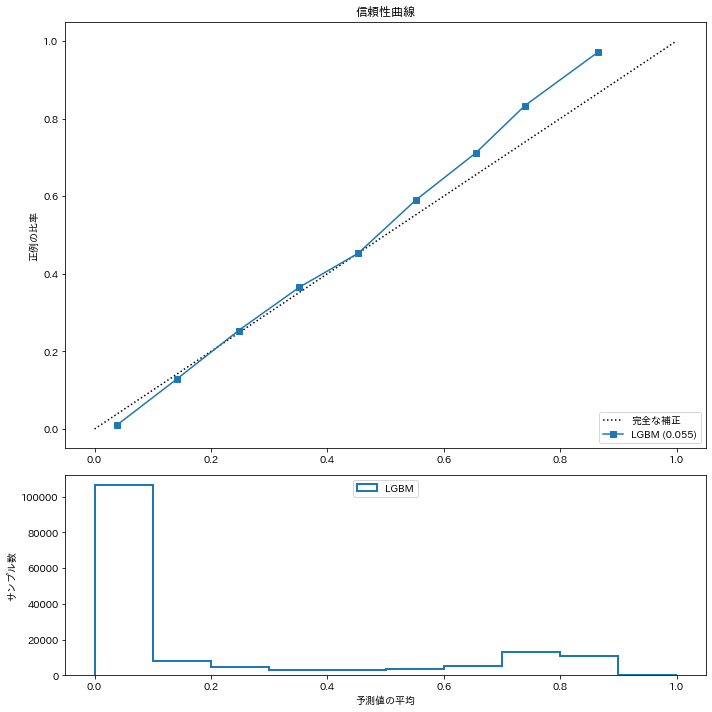

In [ ]:
plot_calib_plots(dict(LGBM=lgbm))

AUCスコア [sklearn.metrics.auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc) は、予測値大小関係（ランキング）の精度を図りますが、
Brierスコア [sklearn.metrics.brier_score_loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html#sklearn.metrics.brier_score_loss) は予測値と実測値（実際のラベル）の近さを図ります。

信頼性曲線を描くには、まず試験データに対する予測値を昇順に便宜上10ビンに分けます。それぞれのビンで予測値の平均を横座標に、実際のラベルの平均（つまり正例の比率）を縦座標に点をプロットします。これらの点を繋げると信頼性曲線になります。理想的な補正がされた場合、予測値の平均が正例の比率に一致し、傾き45%の「完全な補正」直線になります。

ご覧のように、LightGBMモデルの予測値の信頼性曲線は理想的な補正直線に沿っています。


次に、LightGBMの is_unbalance フラッグをオンにしてみましょう。


In [ ]:
lgbm_ubl = LGBMClassifier(**lgbm_params, is_unbalance=True)
lgbm_ubl.fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, n_estimators=20, random_state=2020)

UnbalancedLGBM:
	AUC  : 0.971
	Brier: 0.064



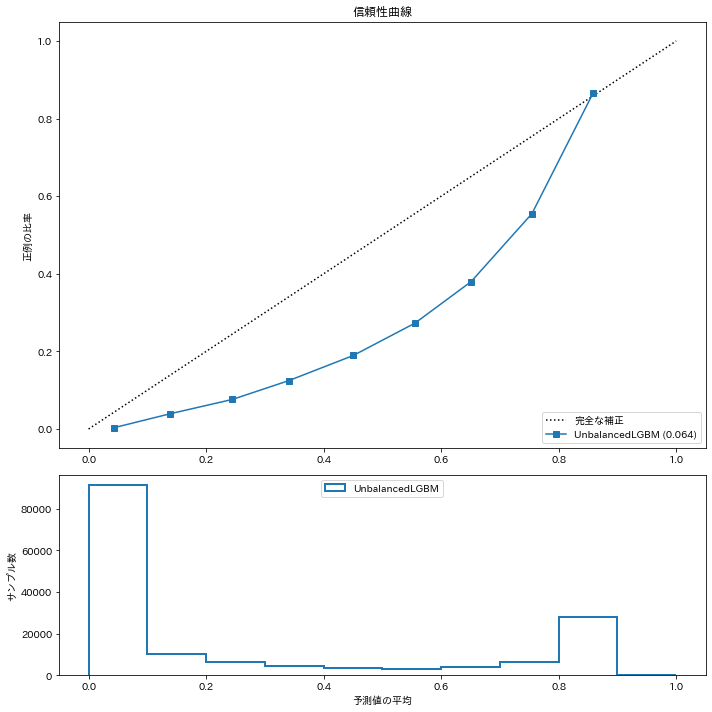

In [ ]:
plot_calib_plots(dict(UnbalancedLGBM=lgbm_ubl))

LightGBMの [is_unbalance](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm-lgbmclassifier)
フラッグは、不均衡データに効き、AUCスコアなどの改善が期待できます。しかし、上図のように予測値がクラス確率から乖離していて、モデルが概ね自信過剰になっています。


## 確率補正の実施

最初に学習データの一部を確立補正用に分けてあります。補正前のベースモデルの学習データと、補正用のデータを分けないと補正時にオーバーフィットが起こってしまうためです。

補正するために[sklearn.calibration. CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV)を使います。 `cv = "prefit"` と指定することによって、ベースモデルが学習済みであり、補正モデルに渡すデータは全量補正用であることを伝えます。補正方法は今回 `isotonic` を使ってみましょう。


In [ ]:
lgbm_ = LGBMClassifier(**lgbm_params, is_unbalance=True)
lgbm_.fit(X_train_, y_train_)
calib = CalibratedClassifierCV(lgbm_, cv="prefit", method="isotonic")
calib.fit(X_calib, y_calib)

CalibratedClassifierCV(base_estimator=LGBMClassifier(is_unbalance=True,
                                                     n_estimators=20,
                                                     random_state=2020),
                       cv='prefit', method='isotonic')

補正前と補正後のモデルの信頼性曲線を同じ図に書いて比較してみましょう。


LGBM:
	AUC  : 0.971
	Brier: 0.064

CalibratedLGBM:
	AUC  : 0.970
	Brier: 0.053



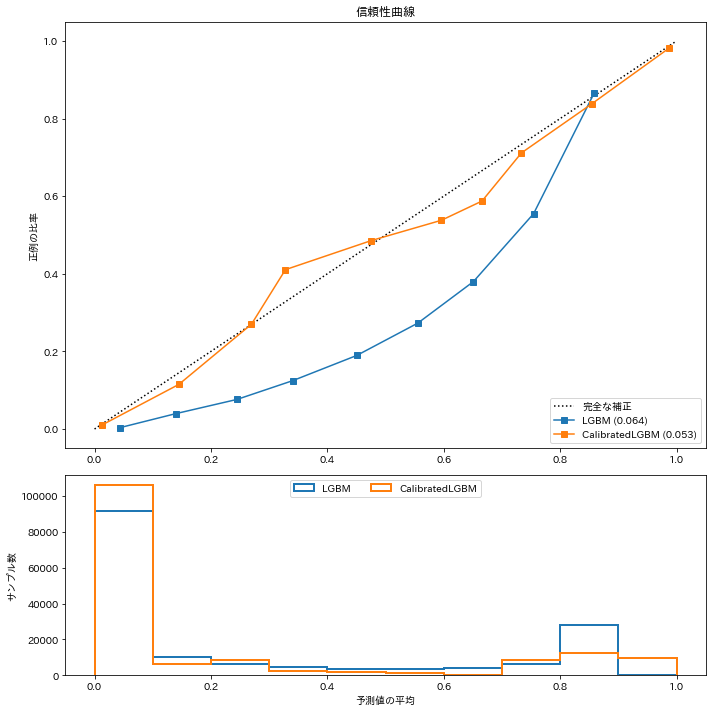

In [ ]:
plot_calib_plots(dict(LGBM=lgbm_ubl, CalibratedLGBM=calib))

補正の結果、信頼性曲線がより理想な傾きに近づき、Brierスコアも改善されました。実運用では、補正用のデータが学習用のデータと完全に分離されたり、データ鮮度がより高かったりして、AUCなどモデルのパフォーマンススコアの改善につながることもあります。


## 最後に

分類モデルの出力値が必ずしもクラス確率とは限らないので、信頼性曲線を確認したり、確率補正を行ってみました。

次回は、sklearnが規定しているインタフェースを持たない学習済みモデルの補正実験や、
確率補正に関する背景的な理論について書ければと思います。
